In [16]:
import numpy as np 
import pandas as pd
import librosa
import matplotlib.pylab as plt
import IPython.display as ipd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

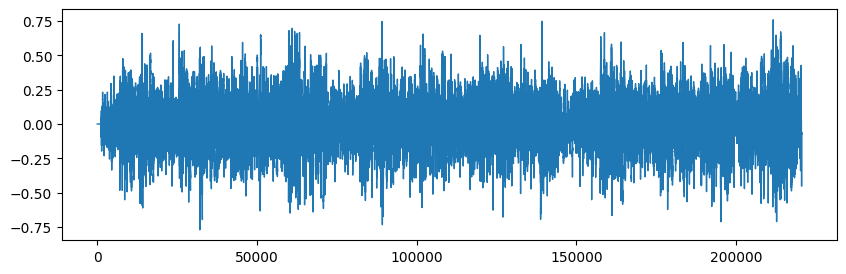

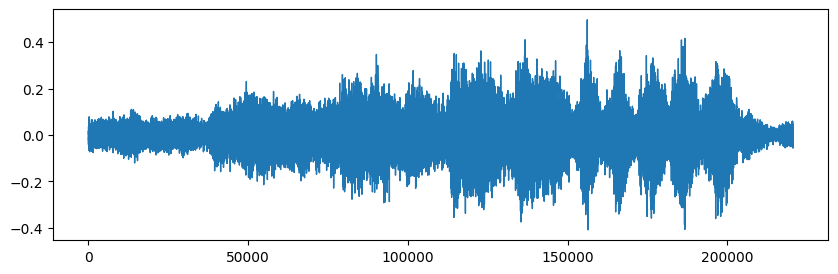

In [18]:
content_path = "input_audio/pirates.mp3"
style_path = "input_audio/Bethoven.wav"

def audio_loader(path):
    audio, sr = librosa.load(path)
    if audio.__len__()>=220500:
        audio = audio[:220500] 
    display(ipd.Audio(audio, rate=22050))
    pd.Series(audio).plot(figsize=(10,3), lw=1)
    plt.show()
    return audio, sr

content, sr = audio_loader(content_path)
style, _ = audio_loader(style_path)
size = (1025, 430)

In [19]:
def Audio_transform(aud, size):
    stft = librosa.stft(aud)
    mag, _ = librosa.magphase(stft)  
    mag = np.log1p(mag)

    mag_min, mag_max = mag.min(), mag.max()
    mag_norm = (mag - mag_min) / (mag_max - mag_min)
    mag_norm = mag_norm[:size[0], :size[1]]
    return mag_norm , mag_min, mag_max

def Img_from_aud(mag_norm):
    data = (mag_norm * 255).astype(np.uint8)
    img = Image.fromarray(data, mode='L')
    return img

def Image_to_Audio(img, mag_min, mag_max):
    mag_norm = np.array(img.cpu().detach(), dtype=np.float32) / 255
    mag = mag_norm * (mag_max - mag_min) + mag_min
    mag = np.exp(mag) - 1
    return librosa.griffinlim(mag)

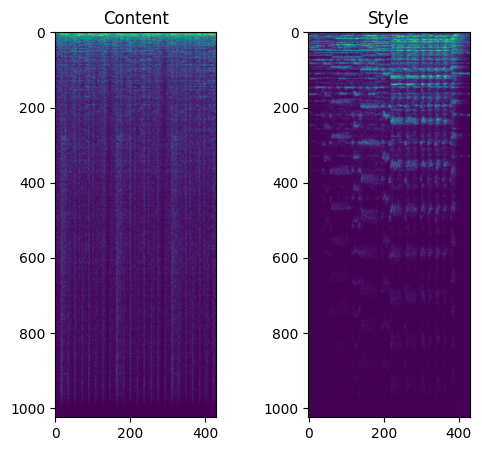

In [20]:
content_norm, mag_min, mag_max= Audio_transform(content,size)
content_img = Img_from_aud(content_norm)
style_norm, _, _= Audio_transform(style, size)
style_img = Img_from_aud(style_norm)

content_array = np.array(content_img).T[None, None, :, :]
style_array = np.array(style_img).T[None, None, :, :]
content_tensor = torch.tensor(content_array, dtype=torch.float32, requires_grad=True)
style_tensor = torch.tensor(style_array, dtype=torch.float32, requires_grad=True)

content_img.save("input_image/cont.jpg","JPEG")
style_img.save("input_image/style.jpg","JPEG")

plt.figure(figsize=(6, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(content_img)
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(style_img)
plt.show()

In [21]:
imsize = 512 if torch.cuda.is_available() else 128 

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()]) 


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader('input_image/style.jpg')
content_img = image_loader('input_image/cont.jpg')

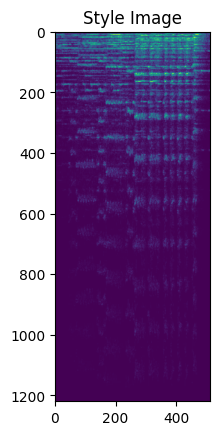

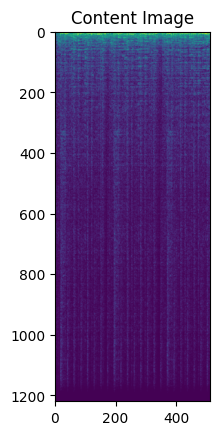

In [22]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [23]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size() 
    features = input.view(a * b, c * d)  

    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

In [24]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [25]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [26]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    normalization = Normalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

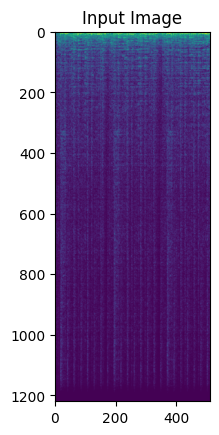

In [27]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [28]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10000000, content_weight=0.0001):
    #Run the style transfer.
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


c:\Users\vansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run [50]:
Style Loss : 504.375336 Content Loss: 0.000655

run [100]:
Style Loss : 65.623352 Content Loss: 0.001129

run [150]:
Style Loss : 4.096275 Content Loss: 0.001232

run [200]:
Style Loss : 1.850735 Content Loss: 0.001257

run [250]:
Style Loss : 2.734338 Content Loss: 0.001294

run [300]:
Style Loss : 0.817644 Content Loss: 0.001303



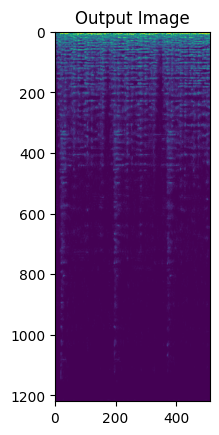

In [29]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

In [30]:
out_aud = Image_to_Audio(output, mag_min, mag_max)
display(ipd.Audio(out_aud[0], rate=22050))